In [1]:
from distmesh import *
from FEM_TPT import *
import numpy as np
import scipy
import math
import matplotlib.pyplot as plt
import csv 

In [2]:
# Finds the committor, the reactive current, and the reaction rate for 
# the Duffing oscillator with noise
# dx = p
# dp = -V'(x) - \gamma*p + sqrt{2gamma beta^{-1}}dw
# using the finite element method and the distmesh triangulation
# Mass is assumed to be 1: m = 1.
#
# The committor boundary-value problem: 
#(1): p*dq/dx - V'(x)*dq/dp + \gamma*[-p*(dq/dp) + \beta^{-1}*(d^2q/dp^2)] = 0, (x,p) \in (A\cup B)^c
# q(\partial A) = 0, q(\partial B) = 1
# dq/dn = 0, (x,p) \in outer boundaty defined by {(x,p) : H(x,p) = Hbdry}
#
# The homogeneous Neumann boundary condition dq/dn = 0 means that 
# the trajectory reflects from the outer boundary whenever it reaches it
#
# We want to put the PDE into a form close to self-adjoint.
# We premultiply (1) by \beta*exp(-\beta p^2/2) and obtain that 
# (1) is equivalent to the following PDE:
#
# \beta*exp(-\beta p^2/2)*[p*dq/dx - V'(x)*dq/dp + \gamma*[-p*(dq/dp) + \beta^{-1}*(d^2q/dp^2)]]=
# \beta*exp(-\beta p^2/2)*[p*dq/dx - V'(x)*dq/dp] + 
# \gamma\nabla*[exp(-\beta p^2/2)*[[0,0],[0,1]]\nabla q] = 0



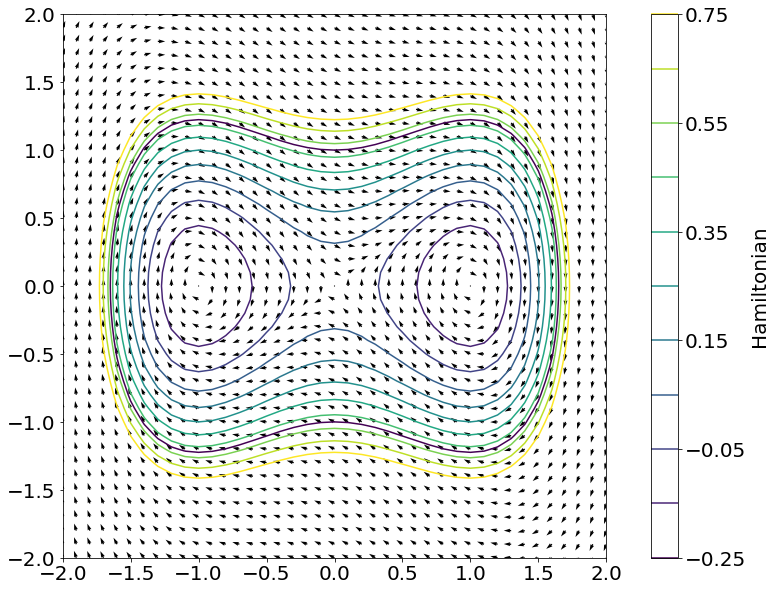

In [3]:
# parameters for the Duffing oscillator with noise:
# X'' + gamma*X' + X^3 - X = \sqrt{2\gamma\beta^{-1}}\eta_t

xa=-1
ya=0 
xb=1 
yb=0

# problem setup: choose sets A and B and the outer boundary
# set A is an ellipse with center at (xa,ya) and radii (rx,ry)
# set B is an ellipse with center at (xb,yb) and radius (rx,ry)
rx = 0.3 # radius of set A
ry = 0.4 # radius of set B
beta = 20.0 # beta = 1/epsilon
Hbdry = 0.5 # the computational domain is bounded by H(x,y)  = Hbdry


# if generate_mesh = True, mesh is generated and saves as csv files
# if generate_mesh = False, mesh is downloaded from those csv files
generate_mesh = True
compute_committor = True
compute_backward_committor = True

# h0 is the desired scalind parameter for the mesh
h0 = 0.02

# parameters for the Duffing oscillator
gamma = 0.5 # friction coefficient
def Hamiltonian(x,y):
    return 0.5*y**2 + 0.25*x**4 - 0.5*x**2

def KE(x):
    return 0.5*x[:,1]**2

def divfree(x,y):
    f1 = y
    f2 = -x**3 + x
    return f1,f2

def drift(x,y):
    f1 = y
    f2 = -gamma*y - x**3 + x
    return f1,f2

# display the direction of the drift on a meshgrid
nx,ny= (41,41)
nxy = nx*ny
xmin = -2.0
xmax = 2.0
ymin = -2
ymax = 2
x1 = np.linspace(xmin,xmax,nx)
y1 = np.linspace(ymin,ymax,ny)
x_grid, y_grid = np.meshgrid(x1,y1)
drift1,drift2 = drift(x_grid,y_grid)
dnorm = np.sqrt(drift1**2+drift2**2+1e-12)
Hgrid = Hamiltonian(x_grid,y_grid)
# graphics
plt.figure(figsize=(16, 10))
plt.rcParams.update({'font.size': 20})
plt.quiver(x_grid,y_grid,drift1/dnorm,drift2/dnorm)
plt.contour(x_grid,y_grid,Hgrid,np.linspace(-0.25,0.75,11))
plt.colorbar(label="Hamiltonian", orientation="vertical")
bplot = plt.contour(x_grid,y_grid,Hgrid,[Hbdry])
axes=plt.gca()
axes.set_aspect(1)



In [4]:
# generate a trajectory
Ntraj = 1000000
h=1e-3 # time step
sqh = math.sqrt(h*2*gamma/beta)
print(sqh)
px = np.zeros((Ntraj,))
py = np.zeros((Ntraj,))
w = sqh*np.random.normal(0,1,(Ntraj-1,));
# initial point
px[0] = xa
py[0] = ya
for k in range(Ntraj-1):
    drift1,drift2 = drift(px[k],py[k])
    px[k+1] = px[k] + drift1*h
    py[k+1] = py[k] + drift2*h + w[k]

Na = int(np.round(np.pi*(rx+ry)/h0)) # the number of points on the A-circle
Nb = int(np.round(np.pi*(rx+ry)/h0)) # the number of points on the B-circle
         
ptsA = put_pts_on_ellipse(xa,ya,rx,ry,Na) 
ptsB = put_pts_on_ellipse(xb,yb,rx,ry,Nb) 

for item in bplot.collections:
    for i in item.get_paths():
        p_outer = i.vertices

pts_outer = reparametrization(p_outer,h0);
Nouter = np.size(pts_outer,axis=0)
Nfix = Na+Nb+Nouter

0.007071067811865475


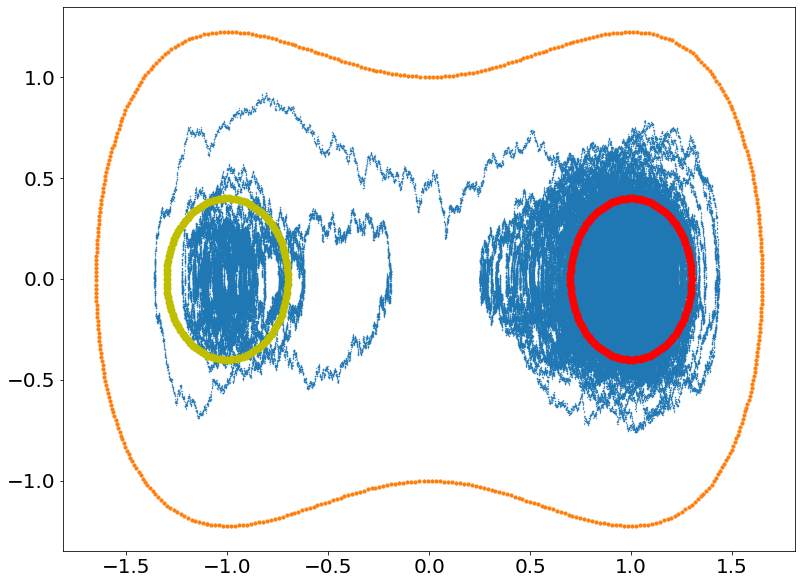

In [5]:
plt.figure(figsize=(16, 10))
plt.scatter(px,py,s=0.1)
plt.scatter(ptsA[:,0],ptsA[:,1],linewidth = 2,c = 'y')
plt.scatter(ptsB[:,0],ptsB[:,1],linewidth = 2,c = 'r')
plt.scatter(pts_outer[:,0],pts_outer[:,1],s=10)
axes=plt.gca()
axes.set_aspect(1)

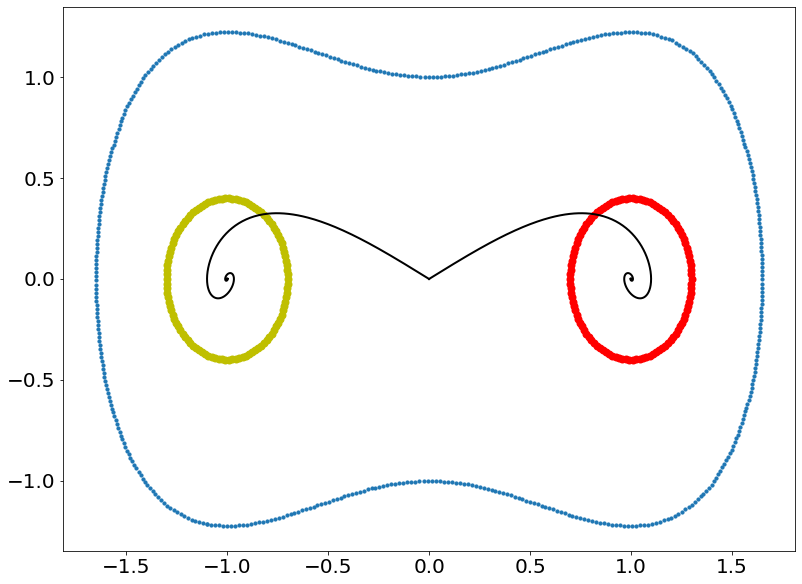

In [6]:
# Generate and plot the maximum likelihood transition path from (-1,0) to (1,0)
from scipy.integrate import solve_ivp
def fun_min2saddle(t,y):
    return np.array([-y[1],-y[1]+y[0]*(y[0]**2 - 1)])
def fun_saddle2min(t,y):
    return np.array([y[1],-y[1]-y[0]*(y[0]**2 - 1)])
# def event(t,y):
#     return np.abs(np.abs(y[0]) - 1) + np.abs(y[1]);
    
sol0 = solve_ivp(fun_min2saddle, (0.0,100.0),np.array([-0.001,0]),method = 'RK45',\
               atol = 1e-12, rtol = 1e-12)
sol1 = solve_ivp(fun_saddle2min, (0.0,100.0),np.array([0.001,0]),method = 'RK45',\
               atol = 1e-12, rtol = 1e-12)

plt.figure(figsize=(16, 10))
plt.scatter(ptsA[:,0],ptsA[:,1],linewidth = 2,c = 'y')
plt.scatter(ptsB[:,0],ptsB[:,1],linewidth = 2,c = 'r')
plt.scatter(pts_outer[:,0],pts_outer[:,1],s=10)
y = sol0.y
plt.plot(y[0,:],y[1,:],linewidth = 2,c = 'k')
y = sol1.y
plt.plot(y[0,:],y[1,:],linewidth = 2,c = 'k')
axes=plt.gca()
axes.set_aspect(1)


count =  200 displacement =  0.01267898288533647
count =  400 displacement =  0.01769576585487313
Npts =  18724  Ntri =  36741


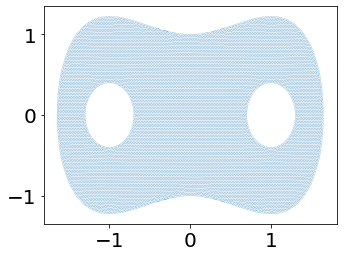

In [7]:
# input data for triangulation
# bbox = [xmin,xmax,ymin,ymax]
if generate_mesh == True:
    bbox = [xmin,xmax,ymin,ymax]
    pfix = np.zeros((Nfix,2))
    pfix[0:Na,:] = ptsA
    pfix[Na:Na+Nb,:] = ptsB
    pfix[Na+Nb:Nfix,:] = pts_outer

    def dfunc(p):
        d0 = Hamiltonian(p[:,0],p[:,1])
        dA = dellipse(p,xa,ya,rx,ry)
        dB = dellipse(p,xb,yb,rx,ry)
        d = ddiff(d0-Hbdry,dunion(dA,dB))
        return d

    pts,tri = distmesh2D(dfunc,huniform,h0,bbox,pfix)
    with open('Duffing_pts.csv', 'w', newline='') as file:
        mywriter = csv.writer(file, delimiter=',')
        mywriter.writerows(pts)

    with open('Duffing_tri.csv', 'w', newline='') as file:
        mywriter = csv.writer(file, delimiter=',')
        mywriter.writerows(tri)
else:
    pts = np.loadtxt('Duffing_pts.csv', delimiter=',', dtype=float)
    tri = np.loadtxt('Duffing_tri.csv', delimiter=',', dtype=int)

Npts = np.size(pts,axis=0)
Ntri = np.size(tri,axis=0)
print("Npts = ",Npts," Ntri = ",Ntri)    

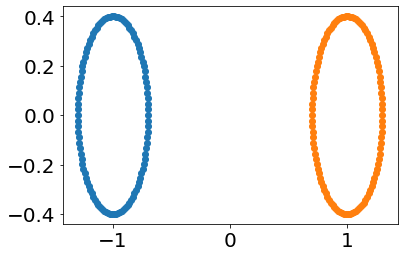

In [8]:
# FEM_committor_solver_irreversible(pts,tri,Aind,Bind,Fpts,drift,divergence,eps05)
NAind,Aind = find_ABbdry_pts_ellipse(pts,xa,ya,rx,ry,h0) # find mesh points on \partial A
NBind,Bind = find_ABbdry_pts_ellipse(pts,xb,yb,rx,ry,h0) # find mesh points on \partial B
plt.scatter(pts[Aind,0],pts[Aind,1])
plt.scatter(pts[Bind,0],pts[Bind,1])

In [9]:
if compute_committor == True:
    q = FEM_committor_solver_Langevin(pts,tri,Aind,Bind,KE,divfree,beta,gamma)
    # save the mesh point, the committor, and the reactive current
    TPTdata = np.concatenate((pts,np.reshape(q,(Npts,1))),axis = 1)
    with open('Duffing_committor.csv', 'w', newline='') as file:
        mywriter = csv.writer(file, delimiter=',')
        mywriter.writerows(TPTdata)
else:
    data = np.loadtxt('Duffing_committor.csv', delimiter=',', dtype=float)
    q = data[:,2]

0.0 1.0


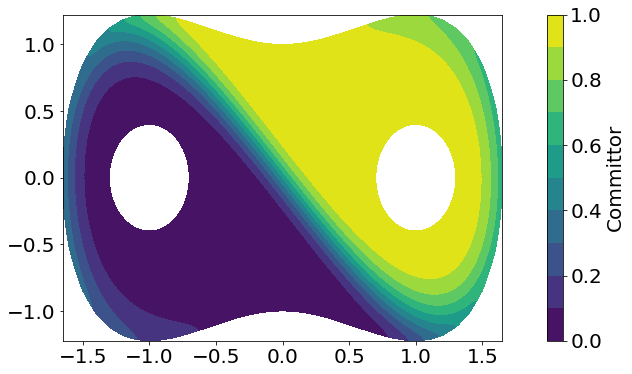

In [10]:
# visualize the committor
qmin = np.amin(q)
qmax = np.amax(q)
print(qmin,qmax)
plt.figure(figsize=(16, 6))
plt.tricontourf(pts[:,0], pts[:,1],tri,q,np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]))
#plt.scatter(pts[:,0],pts[:,1],c=q)
plt.colorbar(label="Committor", orientation="vertical")
axes=plt.gca()
axes.set_aspect(1)
plt.rcParams.update({'font.size': 20})
#plt.savefig('Duffing_committor.pdf')

0.0 1.0


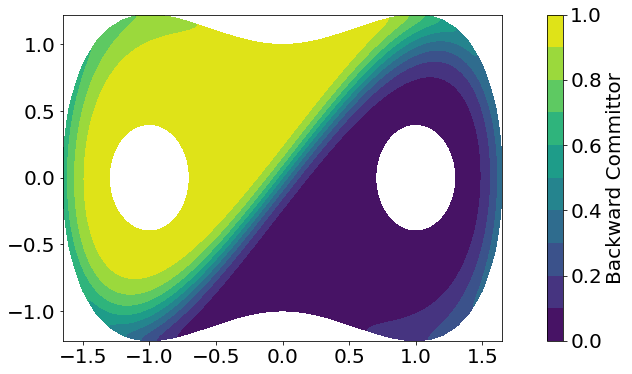

In [11]:
# backward committor satisfies:
#  -p*dq/dx + V'(x)*dq/dp + \gamma*[-p*(dq/dp) + \beta^{-1}*(d^2q/dp^2)] = 0, (x,p) \in (A\cup B)^c
# q(\partial A) = 1, q(\partial B) = 0
# dq/dn = 0, (x,p) \in outer boundaty defined by {(x,p) : H(x,p) = Hbdry}

def divfree1(x,y):
    f1,f2 = divfree(x,y)
    return -f1,-f2

if compute_backward_committor == True:
    qminus = FEM_committor_solver_Langevin(pts,tri,Bind,Aind,KE,divfree1,beta,gamma)
    TPTdata = np.concatenate((pts,np.reshape(qminus,(Npts,1))),axis = 1)
    with open('Duffing_backward_committor.csv', 'w', newline='') as file:
        mywriter = csv.writer(file, delimiter=',')
        mywriter.writerows(TPTdata)
else:
    data = np.loadtxt('Duffing_backward_committor.csv', delimiter=',', dtype=float)
    qminus = data[:,2]    
# visualize the committor
qmin = np.amin(qminus)
qmax = np.amax(qminus)
print(qmin,qmax)
plt.figure(figsize=(16, 6))
plt.tricontourf(pts[:,0], pts[:,1],tri,qminus,np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]))
#plt.scatter(pts[:,0],pts[:,1],c=q)
plt.colorbar(label="Backward Committor", orientation="vertical")
axes=plt.gca()
axes.set_aspect(1)
plt.rcParams.update({'font.size': 20})
# plt.savefig('Duffing_backward_committor.pdf')

count =  200 displacement =  0.0032222354656347603
count =  200 displacement =  0.0032222354695609326
Npts =  1187  Ntri =  2262
Npts =  1187  Ntri =  2262
Z =  [69.3818022]


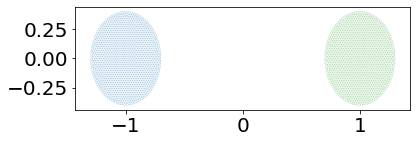

In [12]:
# Triangulate sets A and B. 
# This is necessary for finding the normalization constant Z for the invariant density.

# input data for triangulation
# bbox = [xmin,xmax,ymin,ymax]

def dfuncA(p):
    return dellipse(p,xa,ya,rx,ry)

def dfuncB(p):
    return dellipse(p,xb,yb,rx,ry)

bbox = [xa-rx,xa+rx,ya-ry,ya+ry]
pts_Amesh,tri_Amesh = distmesh2D(dfuncA,huniform,h0,bbox,ptsA)
bbox = [xb-rx,xb+rx,yb-ry,yb+ry]
pts_Bmesh,tri_Bmesh = distmesh2D(dfuncB,huniform,h0,bbox,ptsB)

Npts_Amesh = np.size(pts_Amesh,axis=0)
Ntri_Amesh = np.size(tri_Amesh,axis=0)
print("Npts = ",Npts_Amesh," Ntri = ",Ntri_Amesh) 

Npts_Bmesh = np.size(pts_Bmesh,axis=0)
Ntri_Bmesh = np.size(tri_Bmesh,axis=0)
print("Npts = ",Npts_Bmesh," Ntri = ",Ntri_Bmesh) 

def fpot(x):
    return Hamiltonian(x[:,0],x[:,1])
                         
Z = invariant_pdf(pts,tri,pts_Amesh,tri_Amesh,pts_Bmesh,tri_Bmesh,fpot,beta)
print("Z = ",Z)

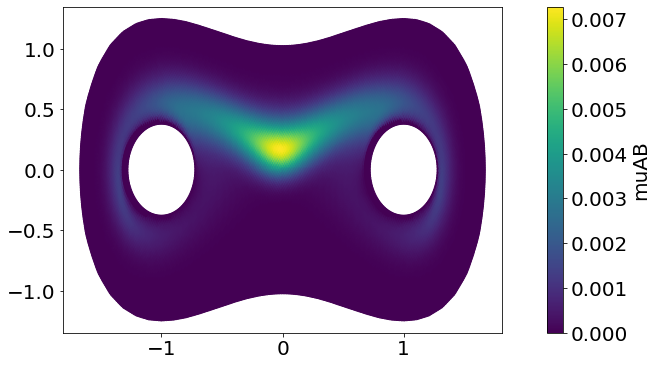

In [13]:
# probability density of reactive trajectories
mu = np.exp(-beta*Hamiltonian(pts[:,0],pts[:,1]))/Z
muAB = mu*q*qminus
plt.figure(figsize=(16, 6))
plt.scatter(pts[:,0], pts[:,1],c = muAB)
#plt.scatter(pts[:,0],pts[:,1],c=q)
plt.colorbar(label="muAB", orientation="vertical")
axes=plt.gca()
axes.set_aspect(1)
plt.rcParams.update({'font.size': 20})
# plt.savefig('Duffing_muAB.pdf')


In [14]:
Rcurrent, Rrate = reactive_current_transition_rate_Langevin(pts,tri,Hamiltonian,divfree,beta,gamma,q,qminus,Z)
print("Rate = ",Rrate)

Rate =  [0.00054904]


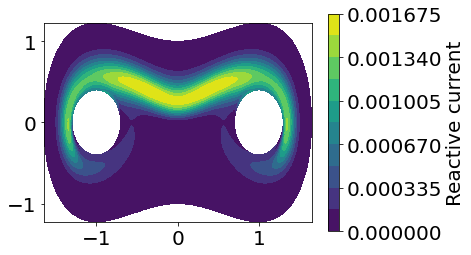

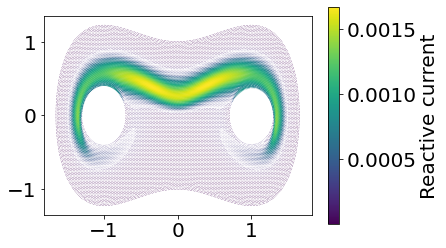

In [15]:
# visualize the reactive current
# find the absolute value of the reactive current
ARcurrent = np.linalg.norm(Rcurrent,axis = 1)
ARCmax = np.amax(ARcurrent)
plt.tricontourf(pts[:,0], pts[:,1],tri,ARcurrent,np.linspace(0,ARCmax,11))
plt.colorbar(label="Reactive current", orientation="vertical")
axes=plt.gca()
axes.set_aspect(1)
plt.rcParams.update({'font.size': 20})
# plt.savefig('Duffing_rcurrent.pdf')
plt.show()

plt.quiver(pts[:,0],pts[:,1],Rcurrent[:,0],Rcurrent[:,1],ARcurrent)
plt.colorbar(label="Reactive current", orientation="vertical")
axes=plt.gca()
axes.set_aspect(1)
plt.rcParams.update({'font.size': 20})
# plt.savefig('Duffing_rcurrent_dir.pdf')

In [16]:
# find the probability that a trajectory is reactive at any randomly picked time t
# \rho_{AB} = \int_{\Omega_{AB}}\mu*qplus*qminus*dx
prob_reactive = probability_reactive_Langevin(pts,tri,Hamiltonian,beta,q,qminus,Z)
print("Probability that a trajectory is reactive at a randomly picked time: ",prob_reactive)

Probability that a trajectory is reactive at a randomly picked time:  [0.00407299]


In [17]:
# find the probability that a trajectory is reactive at any randomly picked time t
# \rho_{A} = \int_{\Omega}\mu*qminus*dx
prob_lastA = probability_last_A_Langevin(pts,tri,pts_Amesh,tri_Amesh,Hamiltonian,beta,qminus,Z)
print("Probability that a trajectory last visited A: ",prob_lastA)

Probability that a trajectory last visited A:  [0.50000003]
